Kaggle Dataset Link: https://www.kaggle.com/competitions/gan-getting-started

### 1. Brief Description of the Problem
For this week's assignment we have been tasked wth submitting a notebook for the "I'm Something of a Painter Myself" Kaggle Competition. Generative adversarial networks (GANs) have been losing popularity but are still extremely relevant. They shine in areas where you can control the latent features, need a feed forward only network and need to generate images quickly, and they perform well in augmenting data. The kaggle compeition task is to take in a certain style of paintings (Monet) and generate more paintings in the same style by either generating new images or transferring the style of Monet to existing photos.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
from keras import layers, ops
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import shutil
import zipfile
import os

### 2. Data Description  
The dataset we have been given are 300 Monet paintings. As well as 7038 photos to transfer to Monet style paintings. The Monet paintings are mostly landscape paintings in a "blurry" fashion. The style is called Impressionism because its short brushstrokes are to relay the impression of the landscape instead of a realistic copy.  
**Painting Dataset Size:** 300  
**Photo Dataset Size:** 7038  
**Image Shape:** (256,256,3)


In [2]:
# our dataset file paths
paint_path = "gan-getting-started/monet_jpg"
photo_path = "gan-getting-started/photo_jpg"
# function to get image from file path
def get_img(file_path):
    img_height = 256
    img_width = 256
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    img = (img / 127.5) - 1.0 # [-1,1]
    return img
# load filenames
paint_file_ds = tf.data.Dataset.list_files(paint_path + "/*.jpg")
photo_file_ds = tf.data.Dataset.list_files(photo_path + "/*.jpg")
# how many photos 
print("{} Monet Paintings".format(paint_file_ds.cardinality()))
print("{} Photographs".format(photo_file_ds.cardinality()))
# convert files to images in tensor dataset
paint_ds = paint_file_ds.map(get_img)
photo_ds = photo_file_ds.map(get_img)
# group 4 together at a time


300 Monet Paintings
7038 Photographs


2025-06-24 08:59:52.487258: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-06-24 08:59:52.487280: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-06-24 08:59:52.487283: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1750769992.487295 14067384 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1750769992.487312 14067384 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


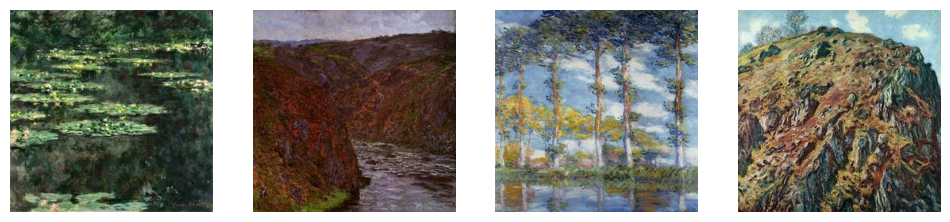

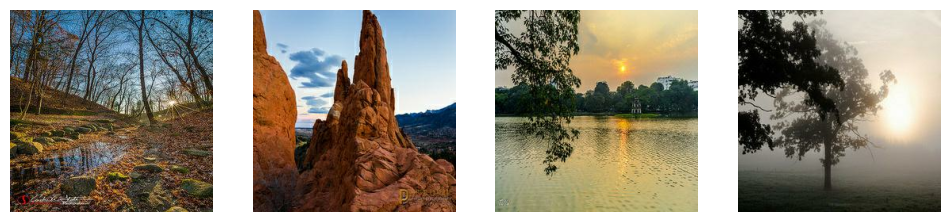

In [3]:
def show_painting(paint_ds):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for ax, img in zip(axes, paint_ds.take(4)):
        img = (img + 1.0) / 2.0
        ax.imshow(img.numpy())
        ax.axis('off')
    plt.show()
def show_photo(photo_ds):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for ax, img in zip(axes, photo_ds.take(4)):
        img = (img + 1.0) / 2.0
        ax.imshow(img.numpy())
        ax.axis('off')
    plt.show()
show_painting(paint_ds)
show_photo(photo_ds)

### 3. Exploratory Data Analysis (EDA)
Lets take a deeper look into our Monet and photo datasets. The main feature engineering we have done to our photo datasets is scaling them to 256x256 pixels and normlaizing their pixel intensity to [-1,1]. From looking at the RGB channel histogram and taking a random 100 entries from both datasets you can see a trend of many more fully black pixels in photos than paintings. This could be attributed to realistic shadows, poor lighting in the photos, or padding. It is interesting to note that we could see the black pixels being removed when we start generating our own images. 

Example image shape: [256 256   3]
File size (bytes) ->
 min: 7575
 median: 16093.0
 max: 26815


2025-06-24 08:59:52.790457: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-24 08:59:52.799359: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-24 08:59:52.857877: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


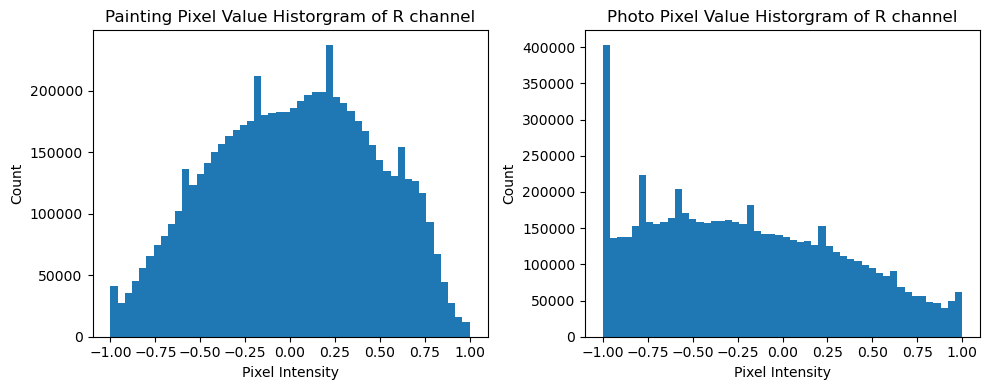

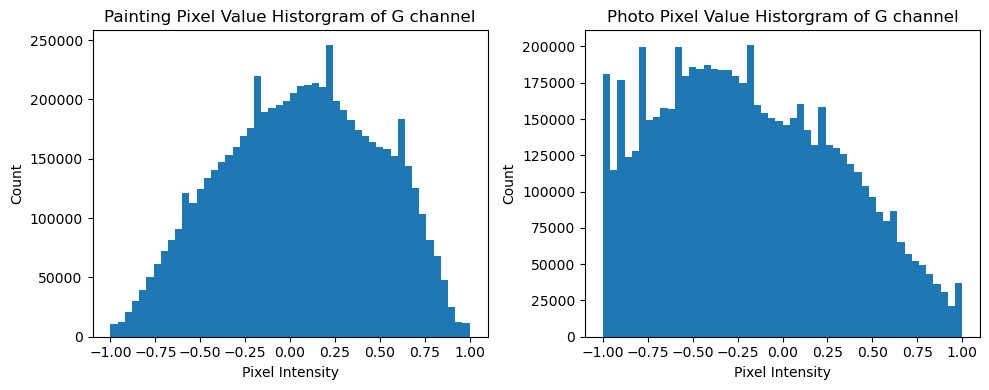

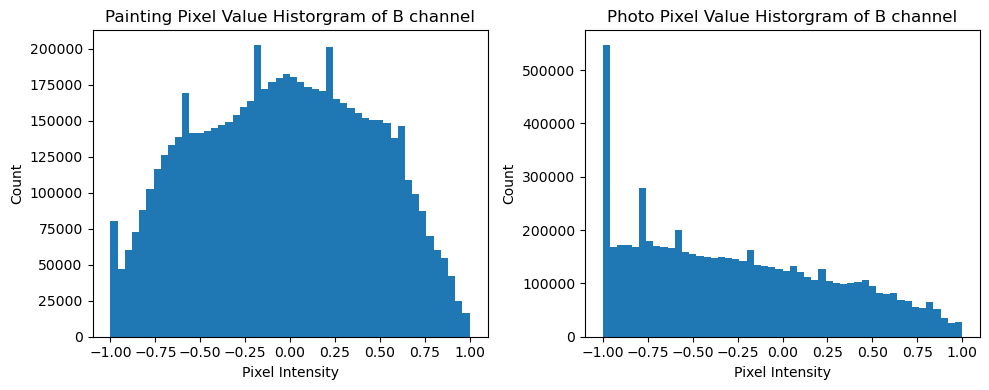

In [4]:
# Shape of images
def example_img_shape(ds):
    for img in ds.take(1):
        img = (img + 1.0) / 2.0
        print("Example image shape: {}".format(tf.shape(img)))

def hist(paint_ds, photo_ds):
    paint_ds = paint_ds.map(lambda img: tf.cast(img, tf.float32))
    photo_ds = photo_ds.map(lambda img: tf.cast(img, tf.float32))
    paint_pixels = []
    photo_pixels = []
    
    for img in paint_ds.take(100):
        paint_pixels.append(img.numpy().reshape(-1, 3))
    paint_pixels = np.concatenate(paint_pixels, axis=0)

    for img in photo_ds.take(100):
        photo_pixels.append(img.numpy().reshape(-1, 3))
    photo_pixels = np.concatenate(photo_pixels, axis=0)
    
    for i, channel in enumerate(['R', 'G', 'B']):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        axes[0].hist(paint_pixels[:, i], bins = 50)
        axes[0].set_title('Painting Pixel Value Historgram of {} channel'.format(channel))
        axes[0].set_xlabel('Pixel Intensity')
        axes[0].set_ylabel('Count')
        
        axes[1].hist(photo_pixels[:, i], bins = 50)
        axes[1].set_title('Photo Pixel Value Historgram of {} channel'.format(channel))
        axes[1].set_xlabel('Pixel Intensity')
        axes[1].set_ylabel('Count')
        
        plt.tight_layout()
        plt.show()

def file_sizes(file_path_ds):
    sizes = []
    for path in file_path_ds:
        p = path.numpy().decode()
        sizes.append(os.path.getsize(p))
    
    sizes = np.array(sizes)
    print("File size (bytes) ->\n min: {}\n median: {}\n max: {}".format(sizes.min(), np.median(sizes), sizes.max()))

############
example_img_shape(paint_ds)
file_sizes(paint_file_ds)
hist(paint_ds, photo_ds)

### 4. Model Architecture & Hyperparameter Tuning
The model I've decided to use is the Deep Convolutional GAN (DCGAN). I decided to use this over fully-connected GAN (ANN GAN) because the convolution filters have less parameters to train for image synthesis and generation.

In [5]:
# Start with code from lectures and class resources
# Added layers to our lecture code to be able to handle a 256x256 image
discriminator = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

latent_dim = 128
# added layers to our lecture code to be able to produce a 256x256 image
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(16 * 16 * 512),
        layers.Reshape((16, 16, 512)),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,984,129 (26.64 MB)

 Trainable params: 6,984,129 (26.64 MB)

 Non-trainable params: 0 (0.00 B)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 131072)         │    16,908,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 256, 256, 32)   │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 3)    │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,696,451 (75.14 MB)

 Trainable params: 19,696,451 (75.14 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.generator(random_latent_vectors)
        combined_images = ops.concatenate([generated_images, real_images], axis=0)
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        misleading_labels = ops.zeros((batch_size, 1))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))


dataset = keras.utils.image_dataset_from_directory(
    paint_path, label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)


epochs = 30

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
paint_ds = paint_ds.batch(4)
gan.fit(
    paint_ds, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Found 300 files.


2025-06-24 08:59:54.052670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - d_loss: 0.2879 - g_loss: 3.8041


In [9]:
# noise = tf.random.normal(shape=(1, latent_dim))
# fake_img = generator(noise, training=False)[0]
# fake_img = (fake_img + 1.0) / 2.0
# plt.figure(figsize=(4,4))
# plt.imshow(fake_img.numpy())
# plt.axis('off')
# plt.show()

### 5. Results & Analysis

In [12]:
# def generated_ds():
#     gen_ds = tf.keras.utils.image_dataset_from_directory(
#     "generated/",
#     label_mode=None,
#     image_size=(256,256),
#     batch_size=32
#     ).map(lambda x: (x / 127.5) - 1.0)
#     return gen_ds
# generated_ds = generated_ds()

import zipfile
import glob

# Collect all generated PNGs
png_files = glob.glob("generated_img_*.png")

# Create a zip archive in the working directory
with zipfile.ZipFile('images.zip', mode='w', compression=zipfile.ZIP_DEFLATED) as zf:
    for fn in png_files:
        zf.write(fn, arcname=fn)

print(f"Zipped {len(png_files)} images into images.zip")


Zipped 30 images into images.zip


### 6. Deliverables Checklist
1. Notebook
2. Github (https://github.com/sam-ghala/week_5_gan)
3. Kaggle submission screenshot

### Kaggle Screenshot
![My Diagram](kaggle_screenshot.png)

### 7. References
https://keras.io/examples/generative/dcgan_overriding_train_step/  
https://www.tensorflow.org/tutorials/generative/dcgan  
- I used these sources to understand the basic DCGAN code template. The first one is from the class lectures and the second one is from the tensorflow documentation.